In [0]:
from google.colab import drive
drive.mount('/content/drive')

file = open('/content/drive/My Drive/Mount.txt', 'r')
mount = file.read()
file.close()

print(mount)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Mount successful!


In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
# Clear session
from tensorflow.keras import backend as K
K.clear_session()

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.applications import Xception

conv_base = Xception(weights='imagenet', 
                  include_top = False, 
                 input_shape=(299, 299, 3))
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
input_tensor = Input(shape=(299, 299, 3))
x = conv_base(input_tensor)
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Flatten()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
output_tensor = layers.Dense(5, activation='softmax')(x)
model = Model(input_tensor, output_tensor)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
print(len(conv_base.layers))

# 0) random weights

# 1) unfreeze all layers
conv_base.trainable = True

# 2) freeze all layers
# conv_base.trainable = False

# 3) unfreeze half layers
# border = 15

# for i, layer in enumerate(conv_base.layers):
#     if i < border:
#         layer.trainable = False
#     else:
#         layer.trainable = True

for layer in conv_base.layers:
    print(layer, layer.trainable)

print(len(conv_base.trainable_weights))

132
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4d486067b8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4d48606048> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4d5dcadac8> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f4d5d648828> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4d486a4d30> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4d482a2a20> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f4d4828f5c0> True
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f4d4833b470> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4d4824cba8> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f4d4824cf60> True
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f4d4826c7b8> True
<tensorflow.python.ker

In [0]:
# train without custom generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
import datetime
from os import listdir, mkdir
from os.path import isfile, isdir, join, exists
import pickle
import random
import math
import time

def seconds_to_m_s(seconds):
    minutes = math.floor(seconds // 60)
    seconds = math.ceil(seconds % 60)
    return minutes, seconds

start_work = time.time()

base_dir = '/content/drive/My Drive/BF_dataset'
logs_dir = join(base_dir, 'logs')

train_dir = join(base_dir, '04_Field_t')
validation_dir = join(base_dir, '04_Field_v')

now_log_dir = join(logs_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

if not exists(now_log_dir):
    mkdir(now_log_dir)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=20,
        target_size=(299, 299),
        color_mode='rgb',
        shuffle=True,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        batch_size=20,
        target_size=(299, 299),
        color_mode='rgb',
        shuffle=True,
        class_mode='categorical')

model.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss='categorical_crossentropy',
              metrics=['acc'])

callback = [TensorBoard(now_log_dir, histogram_freq=1), 
            EarlyStopping(monitor='val_acc', patience=3), 
            ModelCheckpoint(filepath=join(base_dir, 'model_tank5_xcep_best_01.h5'), monitor='val_loss', save_best_only=True)]

history = model.fit(train_generator,
      steps_per_epoch=225,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=75,
      callbacks=callback)

end_work = time.time()
work_time = seconds_to_m_s(end_work - start_work)
print("\nAll work took {} minutes {} seconds".format(work_time[0], work_time[1]))

Found 4500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Epoch 1/30
225/225 [==============================] - 122s 542ms/step - loss: 0.0139 - acc: 0.9993 - val_loss: 0.1712 - val_acc: 0.9367
Epoch 2/30
225/225 [==============================] - 118s 524ms/step - loss: 0.0117 - acc: 0.9993 - val_loss: 0.1755 - val_acc: 0.9400
Epoch 3/30
225/225 [==============================] - 118s 524ms/step - loss: 0.0092 - acc: 0.9998 - val_loss: 0.1778 - val_acc: 0.9407
Epoch 4/30
225/225 [==============================] - 118s 524ms/step - loss: 0.0087 - acc: 0.9998 - val_loss: 0.1811 - val_acc: 0.9400
Epoch 5/30
225/225 [==============================] - 118s 524ms/step - loss: 0.0072 - acc: 0.9998 - val_loss: 0.1851 - val_acc: 0.9393
Epoch 6/30
225/225 [==============================] - 118s 526ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.1888 - val_acc: 0.9380

All work took 12 minutes 1 seconds


In [0]:
model.save(join(base_dir, 'model_tank5_max_xcep_last_01.h5'))

In [0]:
# Data augmentation

start_work = time.time()
base_dir = '/content/drive/My Drive/BF_dataset'
logs_dir = join(base_dir, 'logs')

train_dir = join(base_dir, '04_Field_t')
validation_dir = join(base_dir, '04_Field_v')

now_log_dir = join(logs_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

if not exists(now_log_dir):
    mkdir(now_log_dir)

train_datagen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=20,
        target_size=(299, 299),
        color_mode='rgb',
        shuffle=True,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        batch_size=20,
        target_size=(299, 299),
        color_mode='rgb',
        shuffle=True,
        class_mode='categorical')

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

callback = [TensorBoard(now_log_dir, histogram_freq=1), 
            EarlyStopping(monitor='val_acc', patience=3), 
            ModelCheckpoint(filepath=join(base_dir, 'model_tank5_xcep_aug_best_01.h5'), monitor='val_loss', save_best_only=True)]

history = model.fit(train_generator,
                    steps_per_epoch=225,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=75,
                    callbacks=callback) # 

end_work = time.time()
work_time = seconds_to_m_s(end_work - start_work)
print("\nAll work took {} minutes {} seconds".format(work_time[0], work_time[1]))

Found 4500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Epoch 1/30
225/225 [==============================] - 167s 742ms/step - loss: 0.2901 - acc: 0.8960 - val_loss: 0.2563 - val_acc: 0.9080
Epoch 2/30
225/225 [==============================] - 169s 751ms/step - loss: 0.2440 - acc: 0.9102 - val_loss: 0.2548 - val_acc: 0.9093
Epoch 3/30
225/225 [==============================] - 166s 738ms/step - loss: 0.2289 - acc: 0.9162 - val_loss: 0.2154 - val_acc: 0.9227
Epoch 4/30
225/225 [==============================] - 166s 738ms/step - loss: 0.2023 - acc: 0.9253 - val_loss: 0.1963 - val_acc: 0.9280
Epoch 5/30
225/225 [==============================] - 167s 741ms/step - loss: 0.1761 - acc: 0.9371 - val_loss: 0.1951 - val_acc: 0.9247
Epoch 6/30
225/225 [==============================] - 164s 730ms/step - loss: 0.1603 - acc: 0.9436 - val_loss: 0.1973 - val_acc: 0.9253
Epoch 7/30
225/225 [==============================] - 163s 726ms/step - loss: 0.1531 - acc: 0.9420 -

In [0]:
model.save(join(base_dir, 'model_tank5_xcep_aug_last_01.h5')

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file=join(base_dir, 'model_graph_06.png'))

In [0]:
print(now_log_dir)

/content/drive/My Drive/Tanks_416/logs/20200509-071648


In [0]:
%tensorboard --logdir '/content/drive/My Drive/Tanks_416/logs/20200509-071648'

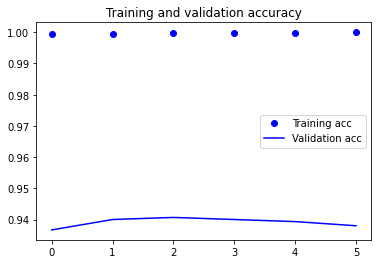

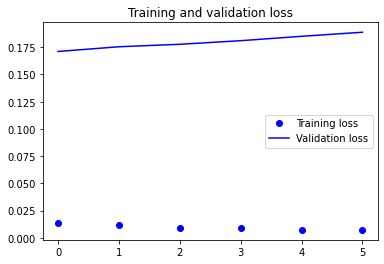

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# Clear session
from tensorflow.keras import backend as K
K.clear_session()

In [0]:
from tensorflow.keras.models import load_model
new_model = load_model(join(base_dir, 'model_tank5_xcep_best_01.h5'))

In [0]:
test_loss, test_acc = new_model.evaluate(validation_generator, steps=75)
print('test acc:', test_acc)

75/75 [==============================] - 14s 186ms/step - loss: 0.1712 - acc: 0.9367
test acc: 0.9366666674613953


In [0]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
import pickle

def prepare_image(img_name):
	image = load_img(img_name, target_size=(299, 299))
	image = img_to_array(image)
	image = image.astype('float32')
	image /= 255.0
	image = expand_dims(image, 0)
	return image

In [0]:
from os import listdir, mkdir
from os.path import isfile, isdir, join, exists
import pickle
import numpy as np

predictions = {}
no_correct = []
correct = []

val_list_folders = [dir for dir in listdir(validation_dir) if isdir(join(validation_dir, dir))]

for val_folder_ind in range(len(val_list_folders)):
    val_folder = val_list_folders[val_folder_ind]
    current_dir = join(validation_dir, val_folder)

    folder_files = [f for f in listdir(current_dir) if isfile(join(current_dir, f))]

    for img_ind in range(len(folder_files)):
        img_name = folder_files[img_ind]
        print('\n{0}/{1} Image name: {2}'.format(img_ind+1, len(folder_files), img_name))

        yhat = new_model.predict(prepare_image(join(current_dir, img_name)))
        print(yhat)

        predictions[img_name] = yhat

        if np.argmax(yhat) != val_folder_ind:
            no_correct.append(img_name)
        else:
            correct.append(img_name)


file = open(join(base_dir, 'tanks5_xcep_pred.p'), 'wb')
pickle.dump(predictions, file)
file.close()

file = open(join(base_dir, 'tanks5_xcep_no_correct.p'), 'wb')
pickle.dump(no_correct, file)
file.close()

file = open(join(base_dir, 'tanks5_xcep_correct.p'), 'wb')
pickle.dump(correct, file)
file.close()

print('Save data!')
print(len(no_correct))
print(len(correct))

# Save data!
# 95
# 1405

In [0]:
for image_name in no_correct:
    print(image_name, np.argmax(predictions[image_name]))


Validation all models

In [0]:
# Clear session
from tensorflow.keras import backend as K
K.clear_session()

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
import datetime
from os import listdir, mkdir
from os.path import isfile, isdir, join, exists
import pickle
import random
import math
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import cv2

def seconds_to_m_s(seconds):
    minutes = math.floor(seconds // 60)
    seconds = math.ceil(seconds % 60)
    return minutes, seconds

base_dir = '/content/drive/My Drive/BF_dataset'

In [0]:
from tensorflow.keras.models import load_model

# Make model
# model = load_model(join(base_dir, 'model_tank5_unfreeze_xcep_last_01.h5')) # 5
# model = load_model(join(base_dir, 'model_tank5_xcep_aug_best_01.h5')) # 6
# model = load_model(join(base_dir, 'model_tank5_xcep_best_01.h5')) # 7
model = load_model(join(base_dir, 'model_tank5_xcep_last_01.h5')) # 8

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 10,245
Non-trainable params: 20,861,480
_________________________________________________________________


In [0]:
start_work = time.time()
base_dir = '/content/drive/My Drive/BF_dataset'

validation_dir = join(base_dir, '04_Field_v')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        batch_size=20,
        target_size=(299, 299),
        color_mode='rgb',
        shuffle=True,
        class_mode='categorical')

test_loss, test_acc = model.evaluate(validation_generator, steps=75)
print('test acc:', test_acc)

end_work = time.time()
work_time = seconds_to_m_s(end_work - start_work)
print("\nAll work took {} minutes {} seconds".format(work_time[0], work_time[1]))

Found 1500 images belonging to 5 classes.
75/75 [==============================] - 1302s 17s/step - loss: 0.2929 - acc: 0.9127
test acc: 0.9126666784286499

All work took 22 minutes 19 seconds


In [0]:
start_work = time.time()
base_dir = '/content/drive/My Drive/BF_dataset'

validation_dir = join(base_dir, '04_Field_v')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        batch_size=20,
        target_size=(299, 299),
        color_mode='rgb',
        shuffle=True,
        class_mode='categorical')

test_loss, test_acc = model.evaluate(validation_generator, steps=75)
print('test acc:', test_acc)

end_work = time.time()
work_time = seconds_to_m_s(end_work - start_work)
print("\nAll work took {} minutes {} seconds".format(work_time[0], work_time[1]))

Found 1500 images belonging to 5 classes.
75/75 [==============================] - 16s 214ms/step - loss: 0.1951 - acc: 0.9247
test acc: 0.9246666431427002

All work took 0 minutes 18 seconds


In [0]:
start_work = time.time()
base_dir = '/content/drive/My Drive/BF_dataset'

validation_dir = join(base_dir, '04_Field_v')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        batch_size=20,
        target_size=(299, 299),
        color_mode='rgb',
        shuffle=True,
        class_mode='categorical')

test_loss, test_acc = model.evaluate(validation_generator, steps=75)
print('test acc:', test_acc)

end_work = time.time()
work_time = seconds_to_m_s(end_work - start_work)
print("\nAll work took {} minutes {} seconds".format(work_time[0], work_time[1]))

Found 1500 images belonging to 5 classes.
75/75 [==============================] - 16s 219ms/step - loss: 0.1712 - acc: 0.9367
test acc: 0.9366666674613953

All work took 0 minutes 19 seconds


In [0]:
start_work = time.time()
base_dir = '/content/drive/My Drive/BF_dataset'

validation_dir = join(base_dir, '04_Field_v')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        batch_size=20,
        target_size=(299, 299),
        color_mode='rgb',
        shuffle=True,
        class_mode='categorical')

test_loss, test_acc = model.evaluate(validation_generator, steps=75)
print('test acc:', test_acc)

end_work = time.time()
work_time = seconds_to_m_s(end_work - start_work)
print("\nAll work took {} minutes {} seconds".format(work_time[0], work_time[1]))

Found 1500 images belonging to 5 classes.
75/75 [==============================] - 16s 214ms/step - loss: 1.1323 - acc: 0.5927
test acc: 0.5926666855812073

All work took 0 minutes 18 seconds
